# Kaggle Titanic survival - PyTorch 'sequential' neural net.

In this workbook we build a neural network to predict survival. The two common frameworks used for neural networks (as of 2020) are TensorFlow and PyTorch. Both are excellent frameworks, but PyTorch is more natively Python in its syntax, and also allows for easier debugging (as the model may be interrupted, with a breakpoint, and debugged as necessary).

Both TensorFlow and PyTorch allow the neural network to be trained on a GPU, which is beneficial for large neural networks (especially those processing image or sound data). 

Installation instructions for PyTorch may be found at pytorch.org. (If in doubt about what installation to use, use `pip install` and use CPU-only, not CUDA).

There are two versions of this workbook. This version uses a simpler form of constructing the neural network. The alternative version uses a class-based method which offers some more flexibility (but at the cost of a little simplicity). It is recommended to work through both methods.

## Load modules

In [1]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

## Download data if not previously downloaded

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [3]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of acuuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted neagtive rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true postive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predicitive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    
    return results

## Define function to scalte data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

Here we use the `sequential` method to set up a PyTorch neural network. This simpler method assumes each layer occurs in sequence. Though simpler, it lacks some flexibility, and does not allow for easy debugging by setting a breakpoint in the middle of the training sequence.

We will put construction of the neural net into a separate function.

The neural net is a simple two layer network, but contains some useful additions (batch normalisation and dropout) as decribed below.

The layers of the network are:

1) An input layer (which does not need to be defined) 
2) A linear fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of outputs. We will expand out feature data set up to 240 outputs.
3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). The layer definition includes the number of inputs to normalise.
4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (`p=0.1` means 10% of outputs are set to zero).
5) An activation layer. In this case ReLU (rectified linear unit). ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.
6) A layer to reduce output of ReLU down to two linear nodes
7) Apply sigmid activation to convert each node to range 0-1 output.

The output of the net are two numbers (corrsponding to scored for died/survived). These do not necessarily add up to one. The one with the highest value will be taken as the classification result.

In [6]:
def make_net(number_features):

    net = torch.nn.Sequential(
            torch.nn.Linear(number_features, 240),
            torch.nn.BatchNorm1d(240),
            torch.nn.Dropout(p=0.1),
            torch.nn.ReLU(240),
            torch.nn.Linear(240,2),            
            torch.nn.Sigmoid())
    
    return net

## Run the model with k-fold validation

In [7]:
# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
k_counter = 0

for train_index, test_index in skf.split(X_np, y_np):
    k_counter +=1
    print('K_fold {}'.format(k_counter),end=' ')
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Scale X data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
        
    net = make_net(number_features)
    
    ### Train model
    # Note: Lots of these parameters may be fine tuned
    
    # Set batch size (cases per batch - commonly 8-64)
    batch_size = 16
    # Epochs (number of times to pass over data)
    num_epochs = 200
    # Learning rate (how much each bacth updates the model)
    learning_rate = 0.003
    # Calculate numebr of batches
    batch_no = len(X_train_sc) // batch_size
    
    # Set up optimizer for classification
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # Train model by passing through the data the required number of epochs
    for epoch in range(num_epochs):
        for i in range(batch_no):
            # Get X and y batch data
            start = i * batch_size
            end = start + batch_size
            x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
            y_var = Variable(torch.LongTensor(y_train[start:end]))
            # These steps train the model: Forward + Backward + Optimize
            optimizer.zero_grad()
            ypred_var = net(x_var)
            loss = criterion(ypred_var, y_var)
            loss.backward()
            optimizer.step()
            
    ### Test model (print results for each k-fold iteration)
    
    test_var = Variable(torch.FloatTensor(X_train_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_train = labels.data.numpy()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_acc_results.append(accuracy_train)
    
    test_var = Variable(torch.FloatTensor(X_test_sc))
    result = net(test_var)
    values, labels = torch.max(result, 1)
    y_pred_test = labels.data.numpy()
    accuracy_test = np.mean(y_pred_test == y_test)
    print(accuracy_test)
    test_acc_results.append(accuracy_test)

K_fold 1 0.8100558659217877
K_fold 2 0.8033707865168539
K_fold 3 0.8146067415730337
K_fold 4 0.7921348314606742
K_fold 5 0.848314606741573


## Show training and test results

In [8]:
# Show individual accuracies on training data
training_acc_results

[0.8665730337078652,
 0.8751753155680224,
 0.8513323983169705,
 0.8401122019635343,
 0.8387096774193549]

In [9]:
# Show individual accuracies on test data
test_acc_results

[0.8100558659217877,
 0.8033707865168539,
 0.8146067415730337,
 0.7921348314606742,
 0.848314606741573]

In [10]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print ('{0:.3f}, {1:.3}'.format(mean_training,mean_test))

0.854, 0.814


## Plot results: Box Plot

Box plots show median (orange line), the secons and third quartiles (the box), the range (excluding outliers), and any outliers as 'whisker' points. Outliers, by convention, are conisdered to be any points outside of the quartiles +/- 1.5 times the interquartile range. The limit for outliers may be changed using the optional `whis` argument in the boxplot.

Medians tend to be an easy reliable guide to the centre of a distribution (i.e. look at the medians to see whether a fit is improving or not, but also look at the box plot to see how much variability there is).

Test sets tend to be more variable in their accuracy measures. Can you think why?

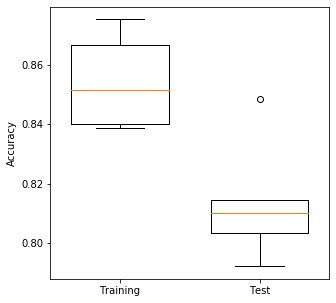

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(111)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()